In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit,minimize

# Define a mirrored Gaussian function (to model negative GPP)
def mirrored_gaussian(x, a, b, c):
    """
    Mirrored Gaussian function:
    a - amplitude (negative value)
    b - mean (Topt)
    c - standard deviation (spread of the peak)
    """
    return -a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Define a fallback cubic polynomial function
def cubic_polynomial(x, a, b, c, d):
    """
    Cubic polynomial function for extrapolation:
    a, b, c, d - polynomial coefficients
    """
    return a * x**3 + b * x**2 + c * x + d

# Function to calculate RMSE
def calculate_rmse(observed, predicted):
    return np.sqrt(np.mean((observed - predicted) ** 2))

# Function to calculate the minimum of a cubic polynomial using optimization
def find_minimum_of_cubic_poly(coeffs, x_range):
    """
    Use optimization to find the minimum of the cubic polynomial.
    """
    # Define the cubic polynomial function
    def poly_func(x):
        a, b, c, d = coeffs
        return a * x**3 + b * x**2 + c * x + d
    
    # Convert x_range to a numpy array and calculate its mean
    x_range_mean = np.mean(np.array(x_range))  # Calculate the mean of the x_range values
    
    # Minimize the cubic polynomial to find the minimum
    result = minimize(poly_func, x_range_mean, bounds=[(min(x_range), max(x_range))])
    return result.x[0]  # Return the x value that minimizes the polynomial


RMSE for Gaussian fit: 0.5535156904379521
Topt is real for 2012 at Site ENF_IT-Ren


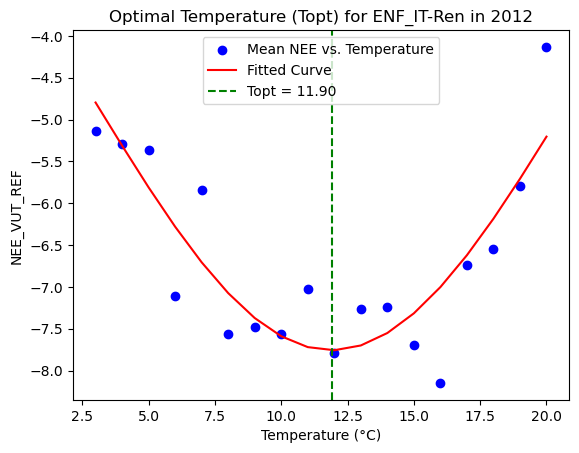

<Figure size 640x480 with 0 Axes>

In [5]:

# Define paths and parameters
base_path = "/home/madse/Downloads/Fluxnet_Data/Alps/"
site_info = pd.read_csv("/home/madse/Downloads/Fluxnet_Data/site_info_all_FLUXNET2015.csv")
plot_data = True  # Set this to False if you don't want to plot the data
save_data = True  # Set this to False if you don't want to save the data
plot_boxplot = False  # Set this to False if you don't want to plot the boxplot

# Initialize a dictionary to hold min values for each site and year
min_nee_temp_dict = {}
min_nee_temp_dict2 = {}
default_Topt = {
    "ENF": 20.0,  # Evergreen Needleleaf Forest
    "DBF": 20.0,  # Deciduous Needleleaf Forest
    "MF_": 20.0,   # Mixed Forest
    "SHB": 20.0,  # Shrubland
    "SAV": 20.0,  # Savanna
    "CRO": 22.0,  # Cropland
    "GRA": 18.0,  # Grassland
}

# Iterate over all folders in the base path that start with "FLX_"
for folder in os.listdir(base_path):
    if folder.startswith("FLX_IT-Ren"):
        file_base = "_".join(folder.split("_")[0:4])
        years = "_".join(folder.split("_")[4:6])
        file_path = os.path.join(base_path, folder, f"{file_base}_HH_{years}.csv")
        
        # Extract site name
        site_name = folder.split("_")[1]
        # get PFT of site
        i = 0
        for site_i in site_info["site"]:
            if site_name == site_i:
                target_pft = site_info["pft"][i]
                if target_pft == "EBF":
                    target_pft = "DBF"  
                if target_pft == "OSH": # TODO check OSH
                    target_pft = "SHB"
                if site_name == "AT-Mie":
                    target_pft = "ENF"
            i += 1
        site_name = target_pft+"_"+site_name

        # Columns to read and converters
        columns_to_copy = [
            "TIMESTAMP_START",
            "TA_F",
            "NEE_VUT_REF",
            "NIGHT",
        ]
        converters = {k: lambda x: float(x) for k in columns_to_copy}

        # Load the data
        df_site = pd.read_csv(file_path, usecols=columns_to_copy, converters=converters)
        df_site["TIMESTAMP_START"] = pd.to_datetime(df_site["TIMESTAMP_START"], format="%Y%m%d%H%M")
        df_site["PFT"] = target_pft
        # Clean the data
        df_site['TA_F'] = df_site['TA_F'].replace(-9999.0, np.nan)
        df_site = df_site.dropna(subset=['TA_F'])
        df_site['NEE_VUT_REF'] = df_site['NEE_VUT_REF'].replace(-9999.0, np.nan)
        df_site = df_site.dropna(subset=['NEE_VUT_REF'])

        # Set the values to np.nan during nighttime
        night_columns = ['NEE_VUT_REF']
        df_site.loc[df_site['NIGHT'] == 1, night_columns] = np.nan

        # Convert units from micromol per m² per second to grams of Carbon per day
        #conversion_factor = 12 * 1e-6 * 60 * 60 * 24  # 12 g C per mol, micromol to mol, per second to per day
        #df_site['NEE_VUT_REF'] *= conversion_factor

        # Resample to daily frequency
        df_site.set_index('TIMESTAMP_START', inplace=True)
        df_daily = df_site.resample('D').agg({
            'TA_F': 'mean',
            'NEE_VUT_REF': 'mean'
        }).dropna()

        # Extract the year from the timestamp
        df_daily['YEAR'] = df_daily.index.year

        # List of unique years
        years = df_daily['YEAR'].unique()

        # Initialize site entry in the dictionary
        if site_name not in min_nee_temp_dict:
            min_nee_temp_dict[site_name] = {}
            min_nee_temp_dict2[site_name] = {}

        # Plot for each year and find min NEE temperature
        for year in years:
            if year == 2012:

                # Filter data for the current year
                df_year = df_daily[df_daily['YEAR'] == year].copy()
                df_year = df_year[df_year['TA_F'] >= 3]

                # Group by each degree of temperature and calculate the mean values
                df_year.loc[:, 'TA_F_rounded'] = df_year['TA_F'].round()
                mean_values = df_year.groupby('TA_F_rounded').mean()

                # Initialize variables
                Topt = np.nan
                fitted_curve = None
                rmse_threshold = 2.0  # Set the RMSE threshold (you can fine-tune this value)

                # First, try to fit the mirrored Gaussian function
                try:
                    # Perform Gaussian fit with mirrored curve (negating amplitude)
                    popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
                    Topt = popt[1]  # Extract the temperature at the peak of the Gaussian (mean)

                    # Generate the fitted curve for plotting or evaluation
                    fitted_curve = mirrored_gaussian(mean_values.index, *popt)

                    # Calculate RMSE for the Gaussian fit
                    rmse = calculate_rmse(mean_values['NEE_VUT_REF'], fitted_curve)
                    print(f"RMSE for Gaussian fit: {rmse}")

                    if site_name == "ENF_DE-Lbk" and year == 2012:
                        rmse_threshold = 1

                    # If RMSE is above threshold, switch to polynomial fit
                    if rmse > rmse_threshold:
                        print(f"RMSE exceeds threshold for {year} at Site {site_name}, switching to polynomial fit.")
                        raise RuntimeError("Gaussian fit RMSE too high")

                    # Check if Topt is within the observed range
                    if Topt < df_year['TA_F_rounded'].max():
                        print(f'Topt is real for {year} at Site {site_name}')
                        real_Topt_col = "green"
                    elif Topt > df_year['TA_F_rounded'].max():
                        print(f"Extrapolated Topt is above observed range for {year} at Site {site_name}")
                        real_Topt_col = "yellow"  # Indicate extrapolated Topt
                    else:                    
                        Topt = default_Topt.get(site_name.split("_")[0])  # Fallback to default if Topt cant be found
                        real_Topt_col = "red"

                except RuntimeError as e:
                    print(f"Gaussian fit failed for {year} at Site {site_name}: {e}")
                    # If RMSE threshold exceeded, use the fallback polynomial fit
                    print("Using fallback cubic polynomial fit.")
                    try:
                        # Perform cubic polynomial fit
                        popt_poly, _ = curve_fit(cubic_polynomial, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
                        
                        # Find the minimum of the cubic polynomial curve (Topt) using optimization
                        Topt = find_minimum_of_cubic_poly(popt_poly, mean_values.index)

                        # Generate the fitted curve for the cubic polynomial
                        fitted_curve = cubic_polynomial(mean_values.index, *popt_poly)

                        # Extend the range and check if Topt is above the highest temperature
                        if Topt > df_year['TA_F_rounded'].max():
                            print(f"Extrapolated Topt is above observed range for {year} at Site {site_name}")
                            real_Topt_col = "yellow"  # Indicate extrapolated Topt
                        else:
                            real_Topt_col = "green"
                    except RuntimeError as e_poly:
                        print(f"Polynomial fit failed for {year} at Site {site_name}: {e_poly}")
                        Topt = default_Topt.get(site_name.split("_")[0])  # Fallback to default if Topt cant be found
                        real_Topt_col = "red"

                # Store the minimum temperature in the dictionary
                if Topt < 5 or Topt > 30:
                    Topt = default_Topt.get(site_name.split("_")[0])  # Fallback to default if Topt cant be found
                    real_Topt_col = "red"

                min_nee_temp_dict[site_name][year] = Topt
                min_nee_temp_dict2[site_name][year] = (Topt,real_Topt_col)

                # Visualization
                plt.scatter(mean_values.index, mean_values['NEE_VUT_REF'], label='Mean NEE vs. Temperature', color='blue')
                if fitted_curve is not None:
                    plt.plot(mean_values.index, fitted_curve, label='Fitted Curve', color='red')
                if not np.isnan(Topt):
                    plt.axvline(Topt, color=real_Topt_col, linestyle='--', label=f'Topt = {Topt:.2f}')
                plt.xlabel('Temperature (°C)')
                plt.ylabel('NEE_VUT_REF')
                plt.legend()
                plt.title(f'Optimal Temperature (Topt) for {site_name} in {year}')
                plt.savefig(
                            os.path.join(base_path, "optimum_temp_"+site_name+"_"+str(year)+".png"),
                            dpi=300,
                            bbox_inches="tight",
                        )
                plt.show()
                plt.clf()
                                


In [8]:

# Convert the dictionary to a DataFrame
min_nee_temp_df = pd.DataFrame(min_nee_temp_dict).T

# Sort the DataFrame by site and year
min_nee_temp_df = min_nee_temp_df.sort_index(axis=0, ascending=True)

# Optionally save the DataFrame to a CSV file
if save_data:
    min_nee_temp_df.to_csv(os.path.join(base_path, 'min_Topt_from_nee_values.csv'))

print(min_nee_temp_df)


                 2013       2014       2005       2006       2007       2008  \
CRO_CH-Oe2  22.414979   8.885368  12.055041  22.686043  11.871657  14.861193   
CRO_DE-Kli  16.432166   9.186438  21.309697  19.306478  27.000000  20.644740   
CRO_FR-Gri  11.873970  10.246851  25.000000  10.115069   9.039778  20.813800   
DBF_DE-Hai        NaN        NaN  19.590750  21.249998  22.187714  19.197496   
DBF_FR-Fon  22.271565  23.534550  21.651360  21.745704  19.974383  19.856875   
DBF_IT-Isp  25.521913  23.206675        NaN        NaN        NaN        NaN   
DBF_IT-PT1        NaN        NaN        NaN        NaN        NaN        NaN   
ENF_CH-Dav   7.867194   9.415081  12.917585   9.676803   9.437197   9.463438   
ENF_DE-Lkb  18.351184        NaN        NaN        NaN        NaN        NaN   
ENF_IT-La2        NaN        NaN        NaN        NaN        NaN        NaN   
ENF_IT-Lav  14.119685  12.502205  13.912419  12.653093  12.809568  13.269231   
ENF_IT-Ren  12.282427        NaN  13.382

<Figure size 1200x800 with 0 Axes>

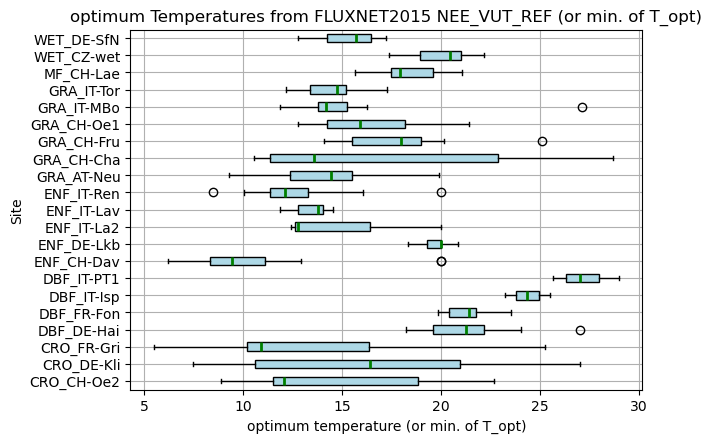

In [9]:


# Plot a boxplot of the temperatures where the minimum NEE occurs for each site
plot_boxplot = True
if plot_boxplot:
    # Convert the DataFrame to a long-form format suitable for plotting
    min_nee_temp_df_long = min_nee_temp_df.reset_index().melt(id_vars='index', var_name='Year', value_name='Temperature')
    min_nee_temp_df_long.rename(columns={'index': 'Site'}, inplace=True)

    plt.figure(figsize=(12, 8))
    # Create the boxplot
    min_nee_temp_df_long.boxplot(column='Temperature', by='Site', showfliers=True, vert=False, patch_artist=True,
                                boxprops=dict(facecolor='lightblue', color='black'),
                                whiskerprops=dict(color='black'),
                                capprops=dict(color='black'),
                                medianprops=dict(color='green', linewidth=2))
    
    plt.xlabel('optimum temperature (or min. of T_opt)')
    plt.ylabel('Site')
    plt.title('optimum Temperatures from FLUXNET2015 NEE_VUT_REF (or min. of T_opt)')
    plt.suptitle('')  # Remove the default 'Boxplot grouped by Site' title
    plt.grid(True)

    # Save the plot to an EPS file
    plt.savefig(
        os.path.join(base_path, "boxplot_Topt_Alps.eps"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()


In [10]:
# Filter the dictionary to exclude entries where real_Topt_col is "red"
filtered_dict = {
    site: {
        year: Topt
        for year, (Topt, color) in year_data.items()
        if color != "red"
    }
    for site, year_data in min_nee_temp_dict2.items()
}

# Convert the filtered dictionary to a DataFrame
filtered_df = pd.DataFrame(filtered_dict).T

# Sort the DataFrame by site and year
filtered_df = filtered_df.sort_index(axis=0, ascending=True)

# Optionally save the filtered DataFrame to a CSV file
if save_data:
    filtered_df.to_csv(os.path.join(base_path, 'filtered_Topt_values.csv'))

# Display the filtered DataFrame
print(filtered_df)


                 2013       2014       2005       2006       2007       2008  \
CRO_CH-Oe2  22.414979   8.885368  12.055041  22.686043  11.871657  14.861193   
CRO_DE-Kli  16.432166   9.186438  21.309697  19.306478  27.000000  20.644740   
CRO_FR-Gri  11.873970  10.246851  25.000000  10.115069   9.039778  20.813800   
DBF_DE-Hai        NaN        NaN  19.590750  21.249998  22.187714  19.197496   
DBF_FR-Fon  22.271565  23.534550  21.651360  21.745704  19.974383  19.856875   
DBF_IT-Isp  25.521913  23.206675        NaN        NaN        NaN        NaN   
DBF_IT-PT1        NaN        NaN        NaN        NaN        NaN        NaN   
ENF_CH-Dav   7.867194   9.415081  12.917585   9.676803   9.437197   9.463438   
ENF_DE-Lkb  18.351184        NaN        NaN        NaN        NaN        NaN   
ENF_IT-La2        NaN        NaN        NaN        NaN        NaN        NaN   
ENF_IT-Lav  14.119685  12.502205  13.912419  12.653093  12.809568  13.269231   
ENF_IT-Ren  12.282427        NaN  13.382

<Figure size 1200x800 with 0 Axes>

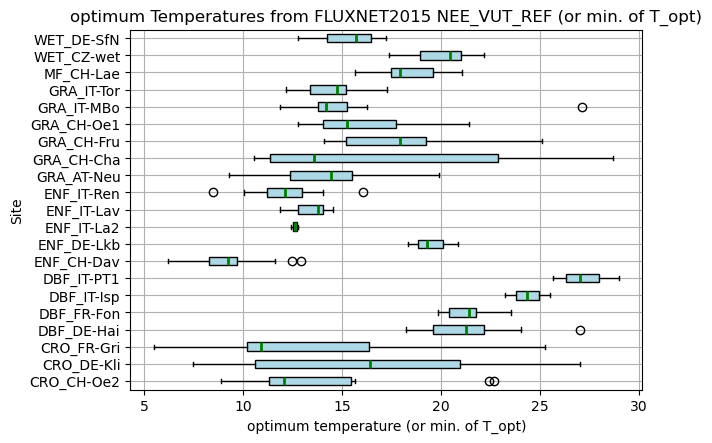

In [11]:


# Plot a boxplot of the temperatures where the minimum NEE occurs for each site
plot_boxplot = True
if plot_boxplot:
    # Convert the DataFrame to a long-form format suitable for plotting
    min_nee_temp_df_long = filtered_df.reset_index().melt(id_vars='index', var_name='Year', value_name='Temperature')
    min_nee_temp_df_long.rename(columns={'index': 'Site'}, inplace=True)

    plt.figure(figsize=(12, 8))
    # Create the boxplot
    min_nee_temp_df_long.boxplot(column='Temperature', by='Site', showfliers=True, vert=False, patch_artist=True,
                                boxprops=dict(facecolor='lightblue', color='black'),
                                whiskerprops=dict(color='black'),
                                capprops=dict(color='black'),
                                medianprops=dict(color='green', linewidth=2))
    
    plt.xlabel('optimum temperature (or min. of T_opt)')
    plt.ylabel('Site')
    plt.title('optimum Temperatures from FLUXNET2015 NEE_VUT_REF (or min. of T_opt)')
    plt.suptitle('')  # Remove the default 'Boxplot grouped by Site' title
    plt.grid(True)

    # Save the plot to an EPS file
    plt.savefig(
        os.path.join(base_path, "boxplot_Topt_Alps.eps"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()


In [12]:
mean_nee_temp_df = min_nee_temp_df.mean(axis=1)
pft = mean_nee_temp_df.index.str[:3]
df = pd.DataFrame({'PFT': pft, 'mean_temp': mean_nee_temp_df.values})
mean_temp_by_pft = df.groupby('PFT')['mean_temp'].mean().reset_index()

print(mean_temp_by_pft)

   PFT  mean_temp
0  CRO  14.956855
1  DBF  23.575142
2  ENF  14.250270
3  GRA  15.881210
4  MF_  18.410165
5  WET  17.641144


In [52]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os

# # Define paths and parameters
# base_path = "/home/madse/Downloads/Fluxnet_Data/Alps/"
# site_info = pd.read_csv("/home/madse/Downloads/Fluxnet_Data/site_info_all_FLUXNET2015.csv")
# plot_data = False  # Set this to False if you don't want to plot the data
# save_data = True  # Set this to False if you don't want to save the data
# plot_boxplot = True  # Set this to False if you don't want to plot the boxplot

# # Initialize a dictionary to hold min values for each site and year
# min_nee_temp_dict = {}
# # Initialize a dictionary to hold real_Topt_col information
# real_Topt_col_dict = {}

# # Iterate over all folders in the base path that start with "FLX_"
# for folder in os.listdir(base_path):
#     if folder.startswith("FLX_"):
#         file_base = "_".join(folder.split("_")[0:4])
#         years = "_".join(folder.split("_")[4:6])
#         file_path = os.path.join(base_path, folder, f"{file_base}_HH_{years}.csv")
        
#         # Extract site name
#         site_name = folder.split("_")[1]
#         # Get PFT of site
#         i = 0
#         for site_i in site_info["site"]:
#             if site_name == site_i:
#                 target_pft = site_info["pft"][i]
#                 if target_pft == "EBF":
#                     target_pft = "DBF"  # TODO check OSH
#                 if target_pft == "OSH":
#                     target_pft = "SHB"
#                 if site_name == "AT-Mie":
#                     target_pft = "ENF"
#             i += 1
#         site_name = target_pft + "_" + site_name

#         # Columns to read and converters
#         columns_to_copy = [
#             "TIMESTAMP_START",
#             "TA_F",
#             "NEE_VUT_REF",
#             "NIGHT",
#         ]
#         converters = {k: lambda x: float(x) for k in columns_to_copy}

#         # Load the data
#         df_site = pd.read_csv(file_path, usecols=columns_to_copy, converters=converters)
#         df_site["TIMESTAMP_START"] = pd.to_datetime(df_site["TIMESTAMP_START"], format="%Y%m%d%H%M")
#         df_site["PFT"] = target_pft

#         # Clean the data
#         df_site['TA_F'] = df_site['TA_F'].replace(-9999.0, np.nan)
#         df_site = df_site.dropna(subset=['TA_F'])
#         df_site['NEE_VUT_REF'] = df_site['NEE_VUT_REF'].replace(-9999.0, np.nan)
#         df_site = df_site.dropna(subset=['NEE_VUT_REF'])

#         # Set the values to np.nan during nighttime
#         night_columns = ['NEE_VUT_REF']
#         df_site.loc[df_site['NIGHT'] == 1, night_columns] = np.nan

#         # Resample to daily frequency
#         df_site.set_index('TIMESTAMP_START', inplace=True)
#         df_daily = df_site.resample('D').agg({
#             'TA_F': 'mean',
#             'NEE_VUT_REF': 'mean'
#         }).dropna()

#         # Extract the year from the timestamp
#         df_daily['YEAR'] = df_daily.index.year

#         # List of unique years
#         years = df_daily['YEAR'].unique()

#         # Initialize site entry in the dictionary
#         if site_name not in min_nee_temp_dict:
#             min_nee_temp_dict[site_name] = {}
#             real_Topt_col_dict[site_name] = {}  # Initialize dictionary for real_Topt_col

#         # Plot for each year and find min NEE temperature
#         for year in years:
#             # Filter data for the current year
#             df_year = df_daily[df_daily['YEAR'] == year].copy()  # Use .copy() to avoid SettingWithCopyWarning

#             # Group by each degree of temperature and calculate the mean values
#             df_year['TA_F_rounded'] = df_year['TA_F'].round()  # Use .loc to avoid SettingWithCopyWarning
#             mean_values = df_year.groupby('TA_F_rounded').mean()

#             # Fit a quadratic polynomial to the mean values
#             coeffs = np.polyfit(mean_values.index, mean_values['NEE_VUT_REF'], 2)
#             poly_fit = np.polyval(coeffs, mean_values.index)

#             # Find the temperature at the minimum of the quadratic fit
#             min_index = mean_values.index[np.argmin(poly_fit)]
#             if min_index < 0:
#                 min_index = np.nan
#             min_value = poly_fit[np.argmin(poly_fit)]

#             # Store the minimum temperature in the dictionary
#             min_nee_temp_dict[site_name][year] = min_index
#             if min_index < df_year['TA_F_rounded'].max():
#                 print(f'Topt is real for {year} at Site {site_name}')
#                 real_Topt_col = "green"
#             else:
#                 real_Topt_col = "red"

#             # Store the real_Topt_col information
#             real_Topt_col_dict[site_name][year] = real_Topt_col

#             # Optionally plot the data
#             if plot_data:
#                 plt.figure(figsize=(10, 6))
#                 plt.scatter(df_year['TA_F'], df_year['NEE_VUT_REF'], color='grey', alpha=0.5, label='Data Points')
#                 plt.plot(mean_values.index, mean_values['NEE_VUT_REF'], color='blue', label='Mean Values')
#                 plt.plot(mean_values.index, poly_fit, color='red', label='Quadratic Fit')
#                 plt.scatter(min_index, min_value, color=real_Topt_col, s=100, label='Minimum Point')
#                 plt.xlabel('Mean daily temperature (TA_F)')
#                 plt.ylabel('Mean NEE (mumol/m²/s)')
#                 plt.title(f'Daily means of temperature vs NEE for {year} at Site {site_name}')
#                 plt.legend()
#                 plt.savefig(
#                     os.path.join(base_path, "optimum_temp_" + site_name + "_" + str(year) + ".eps"),
#                     dpi=300,
#                     bbox_inches="tight",
#                 )

# # Convert the dictionary to a DataFrame
# min_nee_temp_df = pd.DataFrame(min_nee_temp_dict).T


In [53]:

# # Sort the DataFrame by site and year
# min_nee_temp_df = min_nee_temp_df.sort_index(axis=0, ascending=True)

# # Optionally save the DataFrame to a CSV file
# if save_data:
#     min_nee_temp_df.to_csv(os.path.join(base_path, 'min_Topt_from_nee_values.csv'))



# # Convert the DataFrame to a long-form format suitable for plotting
# min_nee_temp_df_long = min_nee_temp_df.reset_index().melt(id_vars='index', var_name='Year', value_name='Temperature')
# min_nee_temp_df_long.rename(columns={'index': 'Site'}, inplace=True)

# # Create a DataFrame for the real_Topt_col information
# real_Topt_col_df = pd.DataFrame([(site, year, col) for site, years in real_Topt_col_dict.items() for year, col in years.items()],
#                                 columns=['Site', 'Year', 'real_Topt_col'])

# # Merge real_Topt_col information with the long-form DataFrame
# min_nee_temp_df_long = min_nee_temp_df_long.merge(real_Topt_col_df, on=['Site', 'Year'])
# min_nee_temp_df_long = min_nee_temp_df_long.sort_values("Site")
# # Create a dictionary for site colors based on real_Topt
# palette = min_nee_temp_df_long['real_Topt_col'].map({'green': 'green', 'red': 'red'})
# print(min_nee_temp_df_long)

In [54]:

# plt.figure(figsize=(12, 8))
# # Create the boxplot
# sns.boxplot(x='Temperature', y='Site', data=min_nee_temp_df_long, palette=palette, showfliers=True,
#             boxprops=dict(edgecolor='black'),
#             whiskerprops=dict(color='black'),
#             capprops=dict(color='black'),
#             medianprops=dict(color='black', linewidth=2))

# plt.xlabel('Optimum Temperature (or Min. of T_opt)')
# plt.ylabel('Site')
# plt.title('Optimum Temperatures from FLUXNET2015 NEE_VUT_REF (or Min. of T_opt)')
# plt.grid(True)
# handles = [
#     plt.Line2D([0], [0], color='green', lw=4, label='Real Topt'),
#     plt.Line2D([0], [0], color='red', lw=4, label='Lower Boundary of Topt')
# ]
# plt.legend(handles=handles, loc='upper right', fontsize=12)
# # Save the plot to an EPS file
# plt.savefig(
#     os.path.join(base_path, "boxplot_optimum_temperatures.eps"),
#     dpi=300,
#     bbox_inches="tight",
# )
# plt.show()
